<a href="https://colab.research.google.com/github/Nuwanthapasindu/paddy-disease-prediction-ai-model/blob/main/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import numpy as np
import matplotlib.pyplot as plt
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!unzip "/content/drive/MyDrive/ML_Learning/paddy-disease-prediction-ai-model/archive.zip"

Archive:  /content/drive/MyDrive/ML_Learning/paddy-disease-prediction-ai-model/archive.zip
replace paddy-disease-classification/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: paddy-disease-classification/sample_submission.csv  
replace paddy-disease-classification/test_images/bacterial_leaf_blight/100023.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace paddy-disease-classification/test_images/bacterial_leaf_blight/100049.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
data_set_path = "/content/paddy-disease-classification"
data_set_train_path = os.path.join(data_set_path, "train_images")
print(data_set_train_path)
data_set_test_path = os.path.join(data_set_path, "test_images")

/content/paddy-disease-classification/train_images


In [ ]:
IMAGE_SIZE = 480
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [ ]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_set_train_path,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 19131 files belonging to 10 classes.


# Data Visualization

In [ ]:
class_names = train_dataset.class_names
class_names

['bacterial_leaf_blight',
 'bacterial_leaf_streak',
 'bacterial_panicle_blight',
 'blast',
 'brown_spot',
 'dead_heart',
 'downy_mildew',
 'hispa',
 'normal',
 'tungro']

In [ ]:
def calculate_class_counts(dataset,folder_path):
  class_names = dataset.class_names
  class_counts = {}
  for class_name in class_names:
    class_dir = os.path.join(folder_path, class_name)
    class_counts[class_name] = len(os.listdir(class_dir))
  return class_counts


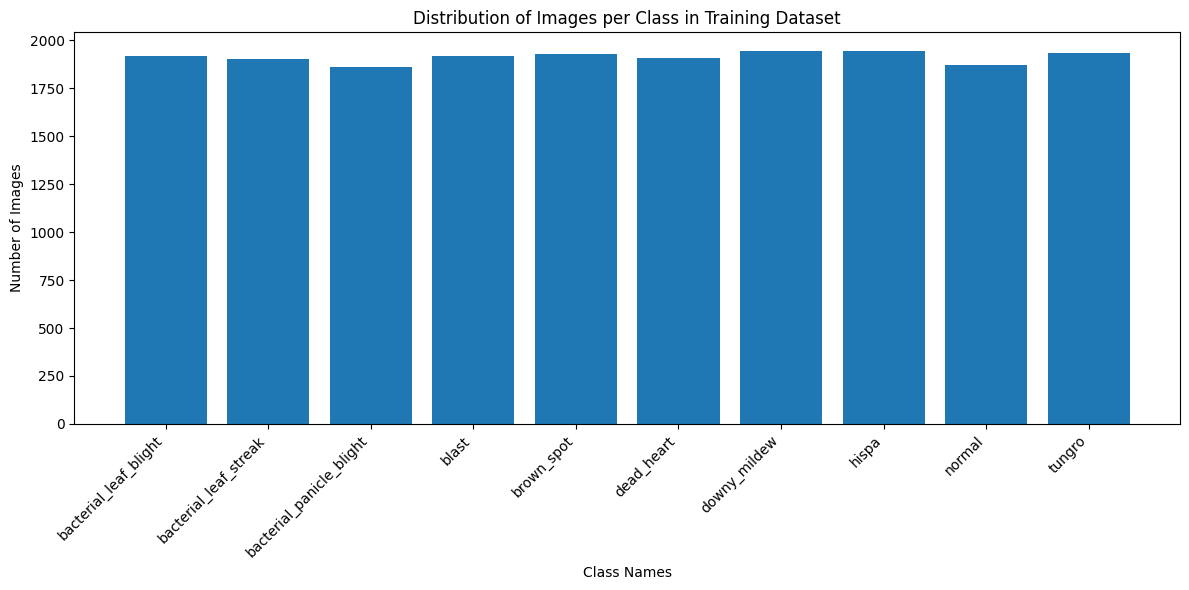

In [ ]:
train_dataset_class_counts = calculate_class_counts(train_dataset,data_set_train_path)
plt.figure(figsize=(12, 6))
plt.bar(train_dataset_class_counts.keys(), train_dataset_class_counts.values())
plt.xticks(rotation=45, ha='right')
plt.xlabel("Class Names")
plt.ylabel("Number of Images")
plt.title("Distribution of Images per Class in Training Dataset")
plt.tight_layout()
plt.show()

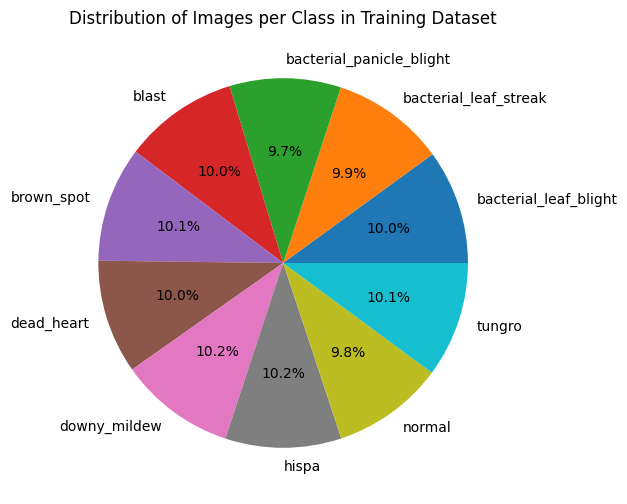

In [ ]:
plt.figure(figsize=(12, 6))
plt.pie(train_dataset_class_counts.values(), labels=train_dataset_class_counts.keys(), autopct='%1.1f%%')
plt.title("Distribution of Images per Class in Training Dataset")
plt.show()

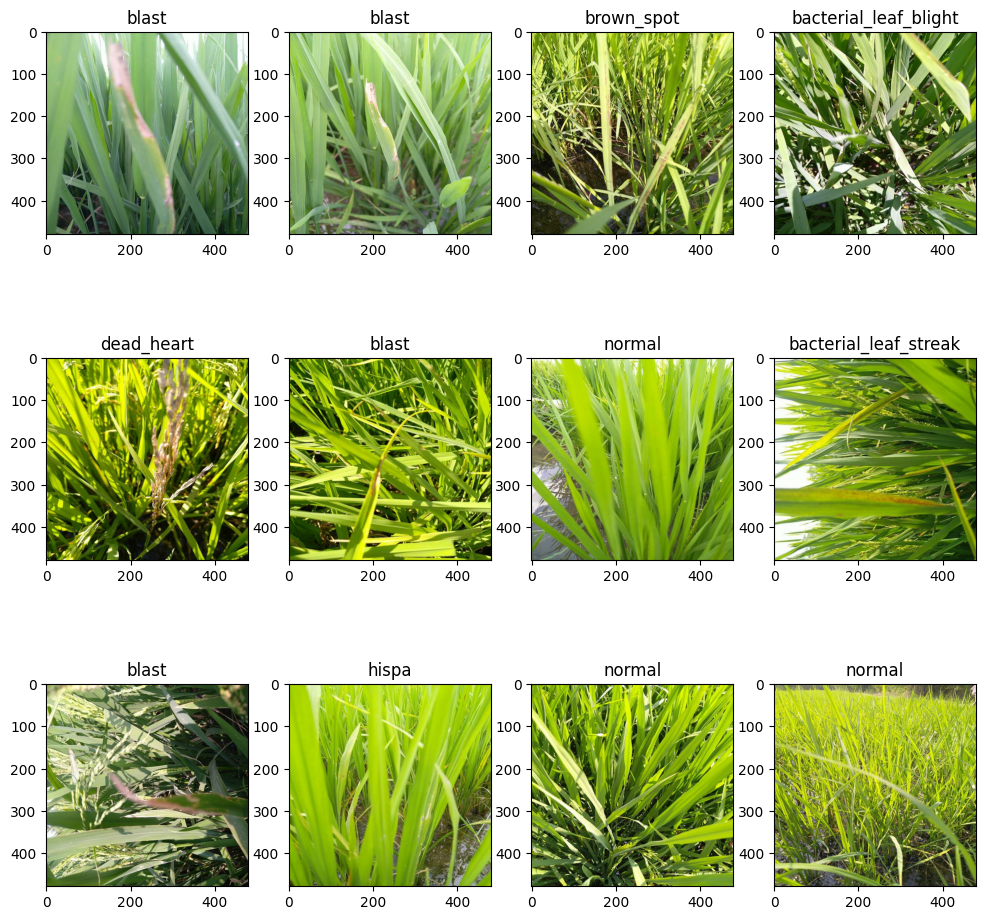

In [86]:
plt.figure(figsize=(12, 12))
for image_batch, label_batch in train_dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])